# Objektdefinition nach der Dissertation von Roger Huckle (2009)

Roger Huckle hat in seiner Dissertation von 2009 einen sehr interessanten Ansatz für die Definition von konvektiven Wolkenobjekten benutzt.

Der Ansatz nutzt den IR<sub>10.8 µm</sub>-Kanal und den VIS<sub>0.6 µm</sub>- Kanal, um die Wolkenobjekte zu definieren. Der Ausgangspunkt ist, dass konvektive Wolken im Vergleich zu ihrer Umgebung relativ kalt und relativ hell sind. Der Knackpunkt ist, wie auch bei allen meinen Versuchen, diese realtiv kalten und hellen Wolken sinnvoll von ihrer Umgebung und Wolken mit gleichen Eigenschaften (Cirrus!) zu trennen.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import tqdm

from standard_config import *
import sys
sys.path.append("{}/utils/tracking".format(local_home_path))
import object_tracking as ot

from l15_msevi import msevi as msv
import datetime as dt
from plotting_tools.colormaps import enhanced_colormap2

## 1. Definition von Hintergrund

Der erste sehr interessante Punkt ist, wie in der Disseration der Hintergrund, also der wolkenfrei Bereich definiert wird. Diese Definition ist wichtig, weil sie ermöglicht Wolken vom wolkenfreien Hintergrund zu trennen.

Die Grundidee ist es, den Median aller IR<sub>10,8 µm</sub>-Helligkeitstemperaturen für all Pixel und alle Zeitschritte zu bilden und das sich so ergebende Bild als wolkenfreie Hintergrundtemperatur anzunehmen. Da die Medianwerte springen können, wird die sich ergebende Kurve nach dem <b>Thermal Surface Parameter</b> (TSP) geglättet und die sich ergebenden Medianwerte als Hintergrund angenommen. Das TSP-Modell (Göttsche & Olesen, 2001) stellt diejenigen Parameter dar, die die Oberflächentemperatur beeinflussen. Die wichtigsten Parameter sind die Sonneneinstrahlung und die Auskühlung in der Nacht. Insgesamt werden sieben Parameter berechnet, die den Tagesgang der Temperatur darstellen. Die sieben Parameter sind in Tabelle 1 aufgeführt.

| Parameter | Bedeutung |
| :- | :-: |
| <i>T</i><sub>0</sub> / °&thinsp;C | Residualtemperatur (etwa zur Sonnenaufgangszeit) |
| <i>T</i><sub>a</sub> / °&thinsp;C | Temperaturamplitude |
| <i>&omega;</i> / hh:mm | Breite der halben Periode des Kosinusterms |
| <i>t</i><sub>m</sub> / Sonnenzeit | Zeitpunkt vom Temperaturmaximum |
| <i>t</i><sub>s</sub> / Sonnenzeit | Startzeitpunkt der Abschwächungsfunktion |  
| <i>k</i> / hh:mm | Abschwächungskonstante |
| <i>&delta;T</i> / °&thinsp;C | Differenz zwischen <i>T</i><sub>0</sub> und <i>T</i><sub>t&rarr;&infin;</sub>|

Diese sieben Parameter werden in der folgenden Gleichungen verwendet, um einen geglätten Tagesgang der Hintergrundtemperatur zu bekommen:

$$
T_{t} =
    \begin{cases}
      T_0 + T_a \text{cos} \left ( \frac{\pi}{\omega} \left ( t - t_m\right) \right ) & t < t_s\\
      (T_0 + \delta T) + \left [ \text{cos} \left ( \frac{\pi}{\omega} \left ( t - t_m\right) \right ) - \delta T \right ] e^\frac{-(t- t_s)}{k}& t > t_s\\
    \end{cases}     
$$

Der Parameter &omega; kann durch die Tageslänge <i>N</i> ersetzt werden, die aus der geographischen Breite &phi; und der Deklination &delta; ermittelt werden kann:

$$ N = \frac{2}{15} \text{arccos} ( -\text{tan}\phi \text{tan}\delta)$$

Die Deklination &delta; ist abhängig vom aktuellen Tag im Jahr <i>d</i> und kann wie folgt berechnet werden:

$$ \delta = -23,45^\circ \text{cos}\left ( \frac{360}{365} (d + 10)\right ) $$.

Um die Funktion stetig zu machen, kann der Parameter <i>k</i> berechnet werden:
    
$$
k = \frac{\omega}{\pi} \left [ \text{arctan} \left ( \frac{\pi}{\omega} (t_s - t_m) - \frac{\delta T}{T_a} \text{arcsin} \left( \frac{\pi}{\omega} (t_s - t_m) \right) \right ) \right]
$$

In [1]:
def declination(n):
    return -23.45 * np.cos(np.deg2rad((360 / 365) * (n + 10)))
                          
def daylight_hours(lat,day_in_year):
    d = np.deg2rad(declination(day_in_year))
    
    return (2/15) * np.arccos(-np.tan(np.deg2rad(lat))*np.tan(d))

def TSP(t,T0,Ta,tm,ts,dT,lat,day_in_year):
    w = np.rad2deg(daylight_hours(lat,diy))

    k = (w / np.pi) * (np.arctan((np.pi / w) * (ts - tm) - (dT / Ta) * np.arcsin((np.pi/w)) * (ts - tm)))
    if t < ts:
        return T0 + Ta * np.cos((np.pi / w) * (t - tm))
    else:
        return (T0 + dT) + (Ta * np.cos((np.pi / w) * (t - tm)) - dT) * np.e**(-(t - ts) / k)

Als nächstes erstellen wir einen wolkenfreien Hinergrund für einen Zeitschritt. Dafür müssen wir die Daten desselben Zeitschritts für die vorangegangenen 30 Tage laden und den Median aller Zellen bilden. 

In [4]:
t = dt.datetime(2012,6,20,12,0)

In [7]:
timesteps = pd.date_range(start="20120522T1200",end="20120620T1200",freq="1d")

In [9]:
len(timesteps)

30

In [15]:
day_data = np.zeros((30,600,800))

In [17]:
for i,ts in enumerate(timesteps):
    try:
        s = msv.MSevi(ts.to_pydatetime(),'eu','rss',['IR_108'])
        s.rad2bt()
        day_data[i] = s.bt['IR_108']
    except:
        continue

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1200z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/29/msg?-sevi-20120529t1200z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t1200z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t1200z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

In [24]:
day_median = np.median(day_data,axis=0)
day_max = np.max(day_data,axis=0)

In [22]:
emap = enhanced_colormap2(vmin=210,vmed1=240,vmed2=270,vmax=300)

Text(0.5, 1.0, 'Maximum')

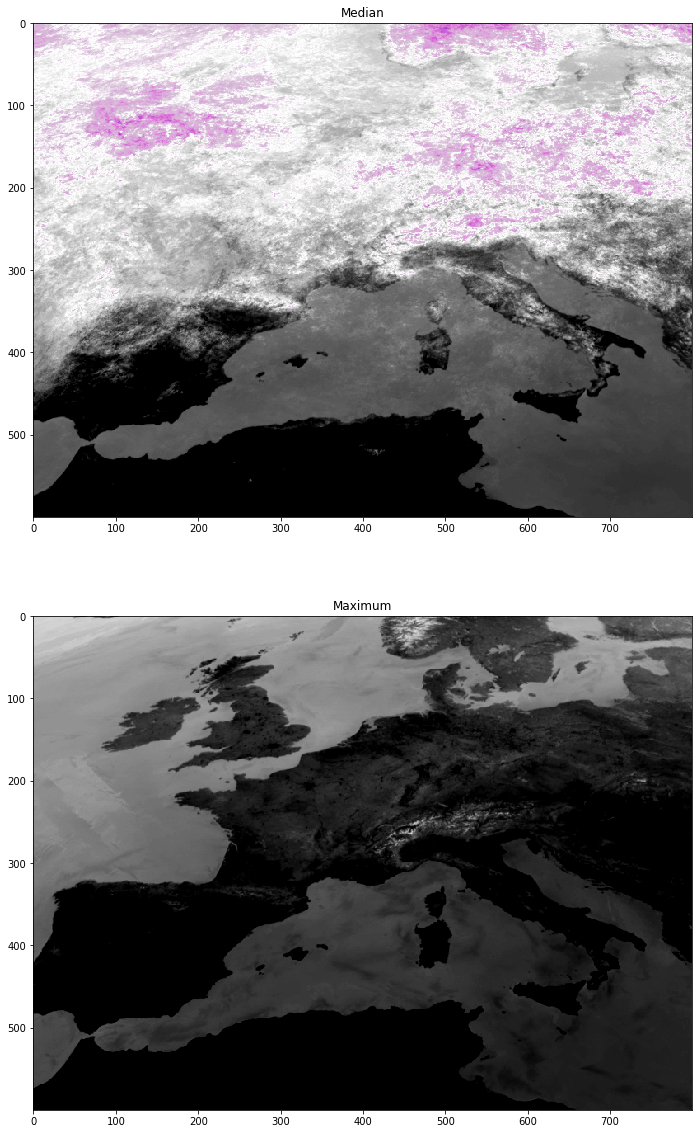

In [25]:
fig,ax = plt.subplots(2,1,figsize=(16,20))
ax[0].imshow(day_median,vmin=210,vmax=300,cmap=emap)
ax[0].set_title("Median")
ax[1].imshow(day_max,vmin=210,vmax=300,cmap=emap)
ax[1].set_title("Maximum")

Im Median sind noch viele Wolken mit drin, als Hintergrund taugt wohl am ehesten das Maximum.

Als nächstes müssen wir das für den ganzen Tag machen.

In [34]:
day_data = np.zeros((288,600,800))

In [35]:
for ti in np.arange(0,289):
    h,m = divmod(ti*5,60)

    times = pd.date_range(start="20120522T{:02d}{:02d}".format(h,m),
                          end="20120620T{:02d}{:02d}".format(h,m),
                          freq="1d")
    
    ts_data = np.zeros((30,600,800))
    
    for i,ts in enumerate(times):
        try:
            s = msv.MSevi(ts.to_pydatetime(),'eu','rss',['IR_108'])
            s.rad2bt()
            ts_data[i] = s.bt['IR_108']
        except:
            continue
            
    day_data[ti] = np.max(ts_data,axis=0)

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t0000z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t0000z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/31/msg?-sevi-20120531t0000z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/31/msg?-sevi-20120531t0000z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t0030z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t0055z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t0055z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/31/msg?-sevi-20120531t0055z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/31/msg?-sevi-20120531t0055z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t0125z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t0150z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t0150z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/31/msg?-sevi-20120531t0150z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/31/msg?-sevi-20120531t0150z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t0220z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t0245z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t0245z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/31/msg?-sevi-20120531t0245z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/31/msg?-sevi-20120531t0245z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t0315z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t0340z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t0340z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/31/msg?-sevi-20120531t0340z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/31/msg?-sevi-20120531t0340z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t0410z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t0435z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t0435z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/31/msg?-sevi-20120531t0435z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/31/msg?-sevi-20120531t0435z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t0505z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t0530z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t0530z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/31/msg?-sevi-20120531t0530z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellit

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t0555z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t0555z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/31/msg?-sevi-20120531t0

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t0625z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t0650z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t0650z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/31/msg?-sevi-20120531t0650z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/31/msg?-sevi-20120531t0650z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t0720z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t0745z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t0745z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/31/msg?-sevi-20120531t0745z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/31/msg?-sevi-20120531t0745z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t0815z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t0815z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf fi

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t0850z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t0850z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf fi

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t0920z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/29/msg?-sevi-20120529t0920z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t0920z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t0920z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t0950z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1015z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/29/msg?-sevi-20120529t1015z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t1015z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t1015z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1045z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1110z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/29/msg?-sevi-20120529t1110z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t1110z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t1110z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1140z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1205z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/29/msg?-sevi-20120529t1205z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t1205z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t1205z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1235z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1300z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/29/msg?-sevi-20120529t1300z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t1300z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t1300z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1330z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1355z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/29/msg?-sevi-20120529t1355z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t1355z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t1355z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1425z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1450z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/29/msg?-sevi-20120529t1450z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t1450z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t1450z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1520z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1545z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/29/msg?-sevi-20120529t1545z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t1545z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t1545z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1615z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1640z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/29/msg?-sevi-20120529t1640z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t1640z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t1640z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1710z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1735z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/29/msg?-sevi-20120529t1735z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t1735z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t1735z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1805z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1830z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/29/msg?-sevi-20120529t1830z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t1830z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t1830z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1900z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1925z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/29/msg?-sevi-20120529t1925z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t1925z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t1925z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t1955z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t2020z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/29/msg?-sevi-20120529t2020z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t2020z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t2020z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t2050z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t2115z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/29/msg?-sevi-20120529t2115z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t2115z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t2115z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t2145z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t2210z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/29/msg?-sevi-20120529t2210z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t2210z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t2210z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t2240z-l15hdf

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t2305z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/29/msg?-sevi-20120529t2305z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/30/msg?-sevi-20120530t2305z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hrit/2012/05/30/msg?-sevi-20120530t2305z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests us

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
ERROR:  /vols/satellite/datasets/eumcst//msevi_rss/l15_hdf/eu/2012/05/29/msg?-sevi-20120529t2335z-l15hdf

ValueError: could not convert string to Timestamp

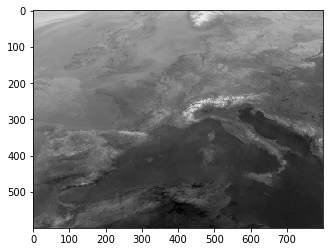

In [40]:
plt.imshow(day_data[287],vmin=210,vmax=300,cmap=emap)

Als nächstes berechnen wir für jeden(!) Pixel ein TSP-Modell.

In [43]:
np.unravel_index(1,(600,800))

(0, 1)

In [47]:
ts = []

for i in np.arange(0,288):
    ts.append(day_data[i][200,200])

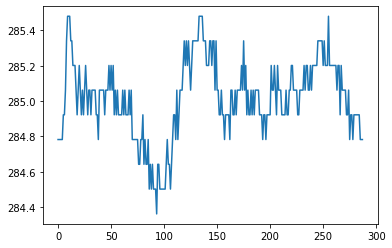

In [48]:
plt.plot(np.arange(0,288),ts)